In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

In [2]:
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
dataroot = "/content/drive/My Drive/Mini Project 3/dataset" 

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# #   All images will be resized to this
# #   size using a transformer.
# image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
def setGPU(netG, netD):
  netG.cuda()
  netD.cuda()

In [0]:
# randomly initialize all weights
# to mean=0, stdev=0.2.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, main):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, main):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):
        return self.main(input)

In [0]:
def phase0():
  # Generator
  mainG = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            #add

            #initially
            nn.ConvTranspose2d( ngf * 8, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 8 x 8
        )
  # Create the generator
  netG = Generator(ngpu, mainG).to(device)

  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.2.
  netG.apply(weights_init)

  #Discriminator
  mainD = nn.Sequential(
            #add

            # input is (nc) x 8 x 8
            nn.Conv2d(nc, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid(),
          )

  # Create the Discriminator
  netD = Discriminator(ngpu, mainD).to(device)

  netD.apply(weights_init)

  setGPU(netG,netD)

  return [netG,netD]

In [0]:
def phase1(netG, netD):
  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
          nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. (ngf*4) x 8 x 8

          nn.ConvTranspose2d( ngf * 4, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 16 x 16
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
      #input is (nc) x 16 x 16
        nn.Conv2d(nc, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
    )

  #we have to change first layer as input_channel is different
  mainD[0] = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())

  setGPU(netG,netD)

In [0]:
def phase2(netG, netD):
  #phase 2 from phase 1

  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
      nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. (ngf*2) x 16 x 16

          nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 32 x 32
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())  

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
      #input is (nc) x 32 x 32
          nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf*2) x 16 x 16
    )
  addD.apply(weights_init)

  #we have to change first layer as input_channel is different 
  mainD[0] = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())
  
  setGPU(netG,netD)

In [0]:
def phase3(netG, netD):
  #phase 3 from phase 2

  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
          nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # state size. (ngf) x 32 x 32

          #initially
          nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 64 x 64
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())  

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
          # input is (nc) x 64 x 64
          nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf) x 32 x 32
    )
  addD.apply(weights_init)

  #we have to change first layer as input_channel is different
  mainD[0] = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
  print(mainD[1].weight)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())  
  print(netD.main[3].weight)
  
  setGPU(netG,netD)

In [0]:
def freeze(netG, netD):
	for param in netG.main.parameters():
		param.requires_grad = False

	for param in netD.main.parameters():
		param.requires_grad = False

def unfreeze(model):
  for param in model.parameters():
    param.requires_grad = True

In [0]:
def debug_freeze(model):
  for child in model.children():
    print(child)
    for param in child.parameters():
      print(param.requires_grad)

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [0]:
def prepare_data(image_size):
  dataset = dset.ImageFolder(root = dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
  # Create the dataloader
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

  # Plot some training images
  real_batch = next(iter(dataloader))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
  return dataloader

In [0]:
def train(netG, netD, image_size):
  dataloader = prepare_data(image_size)

  # Setup Adam optimizers for both G and D
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_losses = []
  iters = 0

  print("Starting Training Loop...")

  for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0 and num_epochs % 10 == 0 :
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch == num_epochs-1): #or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  0# Grab a batch of real images from the dataloader
  real_batch = next(iter(dataloader))

  # Plot the real images
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

  # Plot the fake images from the last epoch
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[-1],(1,2,0)))
  plt.show()

  noise = torch.randn(1, nz, 1, 1, device=device)
  fake = netG(noise).detach().cpu()
  plt.imshow(np.transpose(fake[-1]))

In [0]:
def save_model(phasenum, epoch, netG, netD, loss):
  torch.save({
            'epoch': epoch,
            'modelG_state_dict': netG.state_dict(),
            'modelD_state_dict': netD.state_dict(),
            'loss': loss,
            }, "model_{phasenum}_{epoch}")

def load_model(PATH):
  netG = Generator()
  netD = Descriminator()
  checkpoint = torch.load(PATH)
  netG.load_state_dict(checkpoint['modelG_state_dict'])
  netD.load_state_dict(checkpoint['modelD_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  netG.eval()
  netD.eval()
  return [netG,netD,epoch,loss]

In [19]:
#test
print("Phase0:")
lst = phase0()
netG = lst[0]
netD = lst[1]

Phase0:


Phase1:
Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/150][0/12]	Loss_D: 1.7521	Loss_G: 5.4754	D(x): 0.4453	D(G(z)): 0.5184 / 0.0065
[1/150][0/12]	Loss_D: 0.1571	Loss_G: 9.4404	D(x): 0.9550	D(G(z)): 0.0735 / 0.0001
[2/150][0/12]	Loss_D: 0.0478	Loss_G: 16.0683	D(x): 0.9647	D(G(z)): 0.0000 / 0.0000
[3/150][0/12]	Loss_D: 0.3681	Loss_G: 14.2627	D(x): 0.7954	D(G(z)): 0.0000 / 0.0000
[4/150][0/12]	Loss_D: 0.0723	Loss_G: 5.1942	D(x): 0.9521	D(G(z)): 0.0100 / 0.0073
[5/150][0/12]	Loss_D: 1.0737	Loss_G: 30.0527	D(x): 0.9969	D(G(z)): 0.5778 / 0.0000
[6/150][0/12]	Loss_D: 0.5426	Loss_G: 3.5394	D(x): 0.7015	D(G(z)): 0.0065 / 0.0543
[7/150][0/12]	Loss_D: 2.2484	Loss_G: 1.9095	D(x): 0.2703	D(G(z)): 0.0071 / 0.2548
[8/150][0/12]	Loss_D: 0.4195	Loss_G: 3.3134	D(x): 0.9066	D(G(z)): 0.2396 / 0.0501
[9/150][0/12]	Loss_D: 0.2701	Loss_G: 3.0760	D(x): 0.8643	D(G(z)): 0.1060 / 0.0554
[10/150][0/12]	Loss_D: 0.1836	Loss_G: 3.3970	D(x): 0.9072	D(G(z)): 0.0714 / 0.0433
[11/150][0/12]	Loss_D: 0.1970	Loss_G: 3.6393	D(x): 0.8979	D(G(z)): 0.0753 / 0.0375
[12/150][0/

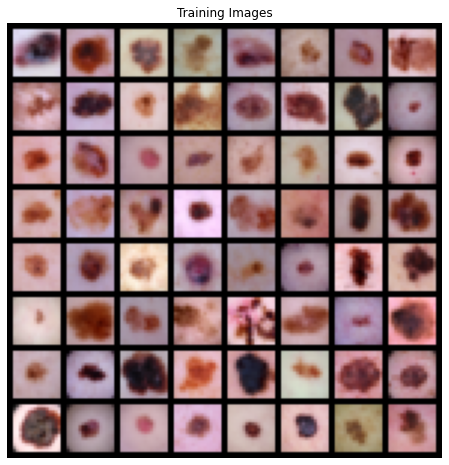

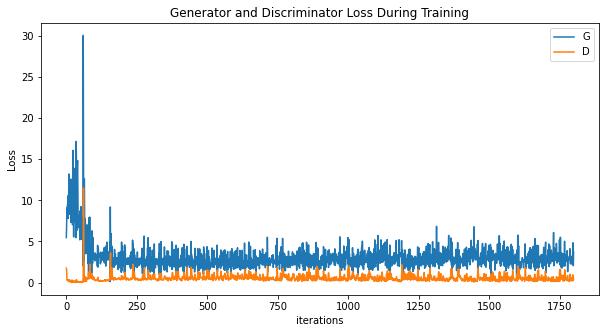

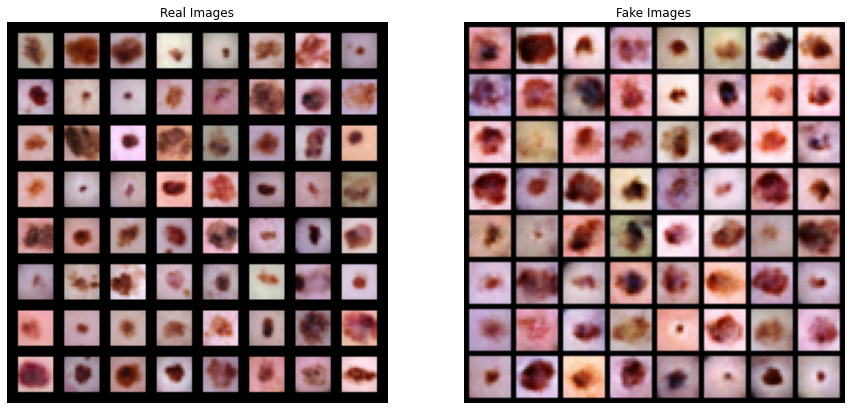

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


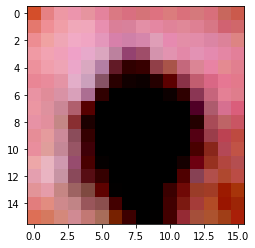

In [20]:
#test
print("Phase1:")
phase1(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 150
train(netG, netD, 16)

# freeze(netG, netD)

In [0]:
# debug_freeze(netG)
# debug_freeze(netD)

In [0]:
# save_model(1,10,netG,netD,0.00)

Phase2:
Starting Training Loop...
[0/150][0/12]	Loss_D: 13.1668	Loss_G: 9.8613	D(x): 0.0001	D(G(z)): 0.0000 / 0.0004
[1/150][0/12]	Loss_D: 0.1594	Loss_G: 11.9439	D(x): 0.9206	D(G(z)): 0.0055 / 0.0001
[2/150][0/12]	Loss_D: 0.2964	Loss_G: 12.4805	D(x): 0.9803	D(G(z)): 0.1395 / 0.0022
[3/150][0/12]	Loss_D: 0.0680	Loss_G: 8.4347	D(x): 0.9577	D(G(z)): 0.0014 / 0.0009
[4/150][0/12]	Loss_D: 2.1623	Loss_G: 18.7509	D(x): 0.8855	D(G(z)): 0.4675 / 0.0000
[5/150][0/12]	Loss_D: 0.9166	Loss_G: 7.3624	D(x): 0.9788	D(G(z)): 0.5015 / 0.0052
[6/150][0/12]	Loss_D: 0.9063	Loss_G: 4.4480	D(x): 0.9377	D(G(z)): 0.4224 / 0.0266
[7/150][0/12]	Loss_D: 0.4107	Loss_G: 3.5812	D(x): 0.8760	D(G(z)): 0.2113 / 0.0400
[8/150][0/12]	Loss_D: 1.3029	Loss_G: 4.9979	D(x): 0.9814	D(G(z)): 0.6572 / 0.0238
[9/150][0/12]	Loss_D: 1.7414	Loss_G: 0.4930	D(x): 0.3309	D(G(z)): 0.0416 / 0.6668
[10/150][0/12]	Loss_D: 0.4939	Loss_G: 4.2700	D(x): 0.9377	D(G(z)): 0.3111 / 0.0243
[11/150][0/12]	Loss_D: 1.4125	Loss_G: 5.0600	D(x): 0.7100	D

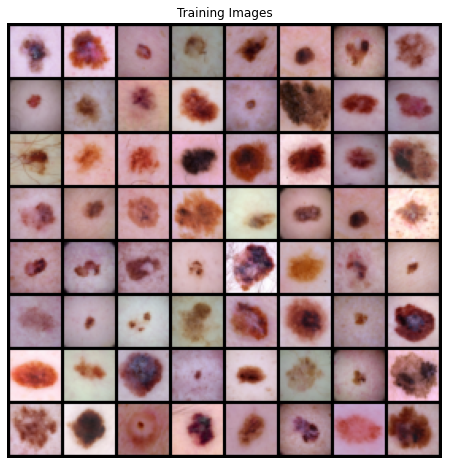

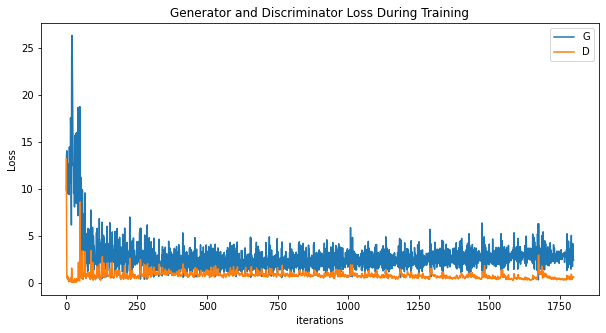

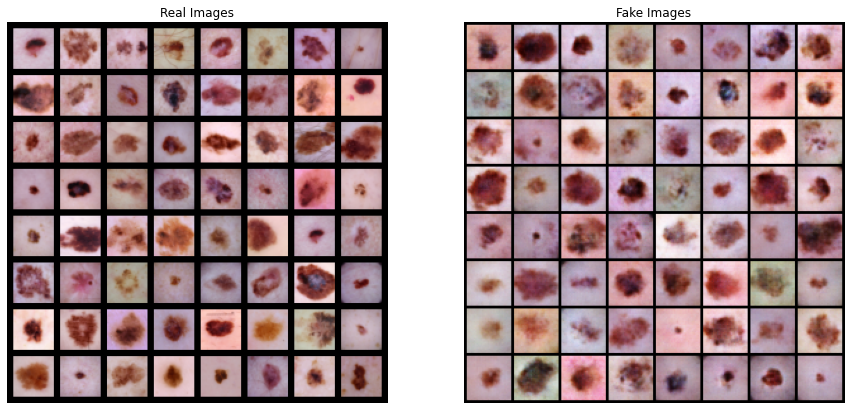

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


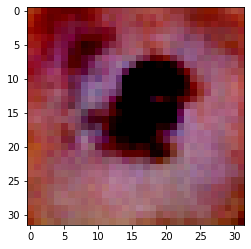

In [21]:
#test
print("Phase2:")
phase2(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 150
train(netG, netD, 32)

# freeze(netG, netD)

Phase3:
Parameter containing:
tensor([1.0139, 1.0002, 1.0309, 0.9847, 1.0178, 0.9819, 0.9846, 1.0068, 0.9790,
        0.9976, 1.0120, 0.9669, 1.0105, 1.0218, 1.0218, 0.9702, 1.0208, 0.9830,
        1.0198, 0.9763, 0.9174, 1.0133, 1.0024, 1.0047, 1.0332, 0.9720, 1.0118,
        1.0084, 1.0017, 1.0181, 1.0078, 0.9569, 1.0111, 1.0222, 0.9968, 0.9723,
        0.9858, 1.0027, 1.0133, 1.0076, 0.9898, 1.0089, 1.0227, 0.9904, 1.0301,
        0.9708, 0.9612, 0.9996, 0.9675, 1.0256, 0.9849, 1.0066, 1.0267, 0.9631,
        1.0020, 0.9660, 0.9998, 0.9734, 1.0064, 1.0482, 0.9764, 1.0060, 0.9891,
        1.0418, 1.0052, 1.0274, 1.0171, 1.0021, 0.9737, 1.0027, 1.0016, 1.0214,
        0.9917, 0.9991, 1.0197, 1.0306, 0.9907, 0.9977, 1.0551, 1.0143, 0.9814,
        1.0158, 0.9944, 0.9753, 0.9720, 1.0157, 0.9968, 1.0156, 0.9918, 1.0216,
        1.0179, 0.9860, 1.0509, 1.0157, 1.0070, 0.9816, 1.0127, 1.0149, 0.9932,
        0.9834, 1.0304, 1.0103, 1.0214, 0.9979, 1.0321, 0.9890, 0.9643, 1.0161,
        0.

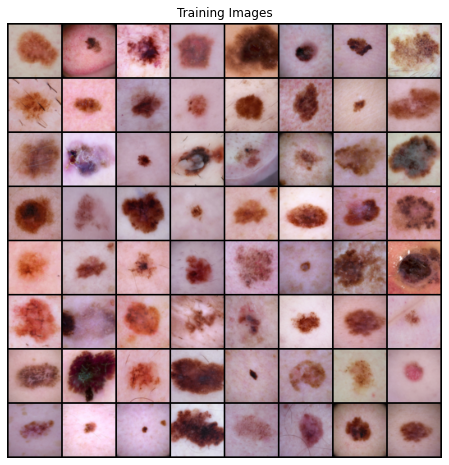

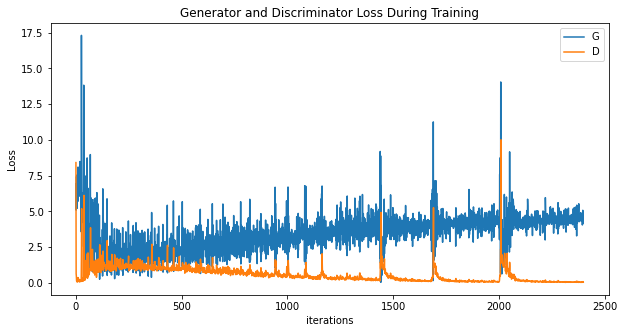

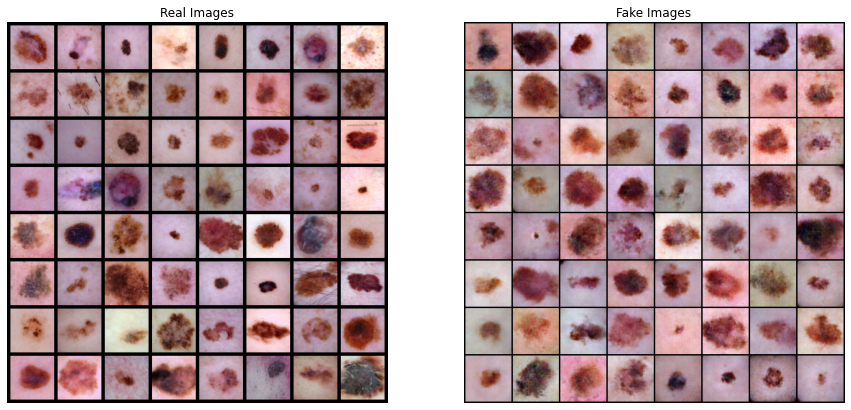

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


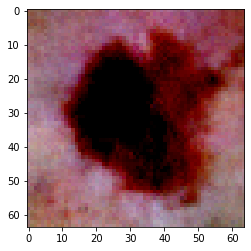

In [22]:
#test
print("Phase3:")
phase3(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 200
train(netG, netD, 64)

# freeze(netG, netD)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


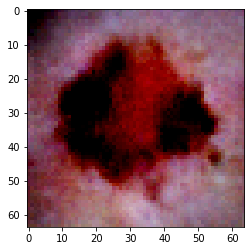

In [23]:
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(noise).detach().cpu()
plt.imshow(np.transpose(fake[-1]))

In [24]:
summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [64, 512, 4, 4]         819,200
       BatchNorm2d-2            [64, 512, 4, 4]           1,024
              ReLU-3            [64, 512, 4, 4]               0
   ConvTranspose2d-4            [64, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [64, 256, 8, 8]             512
              ReLU-6            [64, 256, 8, 8]               0
   ConvTranspose2d-7          [64, 128, 16, 16]         524,288
       BatchNorm2d-8          [64, 128, 16, 16]             256
              ReLU-9          [64, 128, 16, 16]               0
  ConvTranspose2d-10           [64, 64, 32, 32]         131,072
      BatchNorm2d-11           [64, 64, 32, 32]             128
             ReLU-12           [64, 64, 32, 32]               0
  ConvTranspose2d-13            [64, 3, 64, 64]           3,072
             Tanh-14            [64, 3,